In [1]:
import imp
import os

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly

from BuildingControlSimulator.Simulator.Simulation import Simulation
from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
s = Simulation(
    building_model=EnergyPlusBuildingModel(
        idf=IDFPreprocessor(
            idf_name=f"Zone5VAV-Pri-SecLoop_{os.environ['ENERGYPLUS_INSTALL_VERSION']}.idf",
            init_temperature=21.),
        weather_name="USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"
    ),
    controller=Deadband(deadband=2., stp_heat=21., stp_cool=25.),
    step_size_minutes=5,
    start_time_days = 200,
    final_time_days = 203,
)

IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/Zone5VAV-Pri-SecLoop_8-9-0.idf


In [4]:
s.initialize()

Model init starting ...
Complete.


In [5]:
df = s.run()

________________________________________________________________________________
Entering co-simulation loop
________________________________________________________________________________
Simulation finished.


In [6]:
df

,time_seconds,step_status,t_ctrl,HVAC_mode,stp_heat,stp_cool,deadband,FMU_T_heating_stp,FMU_T_cooling_stp,FMU_T_control_type,...,FMU_SPACE4_1_Zone_Thermostat_Cooling_Setpoint_Temperature,FMU_SPACE4_1_Zone_Air_System_Sensible_Heating_Rate,FMU_SPACE4_1_Zone_Air_System_Sensible_Cooling_Rate,FMU_SPACE4_1_Zone_Total_Internal_Total_Heating_Rate,FMU_SPACE5_1_Zone_Air_Temperature,FMU_SPACE5_1_Zone_Thermostat_Heating_Setpoint_Temperature,FMU_SPACE5_1_Zone_Thermostat_Cooling_Setpoint_Temperature,FMU_SPACE5_1_Zone_Air_System_Sensible_Heating_Rate,FMU_SPACE5_1_Zone_Air_System_Sensible_Cooling_Rate,FMU_SPACE5_1_Zone_Total_Internal_Total_Heating_Rate
0,17280000,0,21.000000,0,21.0,25.0,2.0,0.0,0.0,0.0,...,0.0,0.68,0.0,3.62,23.535967,21.0,0.0,0.29,0.0,5.1
1,17280300,0,23.450990,0,21.0,25.0,2.0,0.0,0.0,0.0,...,0.0,0.68,0.0,3.62,23.516581,21.0,0.0,0.29,0.0,5.1
2,17280600,0,23.424719,0,21.0,25.0,2.0,0.0,0.0,0.0,...,0.0,0.68,0.0,3.62,23.498262,21.0,0.0,0.29,0.0,5.1
3,17280900,0,23.403213,0,21.0,25.0,2.0,0.0,0.0,0.0,...,0.0,0.68,0.0,3.62,23.481086,21.0,0.0,0.29,0.0,5.1
4,17281200,0,23.385622,0,21.0,25.0,2.0,0.0,0.0,0.0,...,0.0,0.68,0.0,3.62,23.465105,21.0,0.0,0.29,0.0,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,17537700,0,23.873450,2,21.0,25.0,2.0,0.0,0.0,0.0,...,-60.0,0.68,0.0,3.62,23.755270,21.0,-60.0,0.29,0.0,5.1
860,17538000,0,23.832528,2,21.0,25.0,2.0,0.0,0.0,0.0,...,-60.0,0.68,0.0,3.62,23.736443,21.0,-60.0,0.29,0.0,5.1
861,17538300,0,23.791762,2,21.0,25.0,2.0,0.0,0.0,0.0,...,-60.0,0.68,0.0,3.62,23.717733,21.0,-60.0,0.29,0.0,5.1
862,17538600,0,23.751143,2,21.0,25.0,2.0,0.0,0.0,0.0,...,-60.0,0.68,0.0,3.62,23.699140,21.0,-60.0,0.29,0.0,5.1


In [7]:
df["total_heating"] = (df["FMU_SPACE5_1_Zone_Air_System_Sensible_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Air_System_Sensible_Heating_Rate"])
df["total_cooling"] = (df["FMU_SPACE5_1_Zone_Air_System_Sensible_Cooling_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE3_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE2_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE1_1_Zone_Air_System_Sensible_Cooling_Rate"])

In [8]:
df["total_internal_heat"] = (df["FMU_SPACE5_1_Zone_Total_Internal_Total_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Total_Internal_Total_Heating_Rate"])

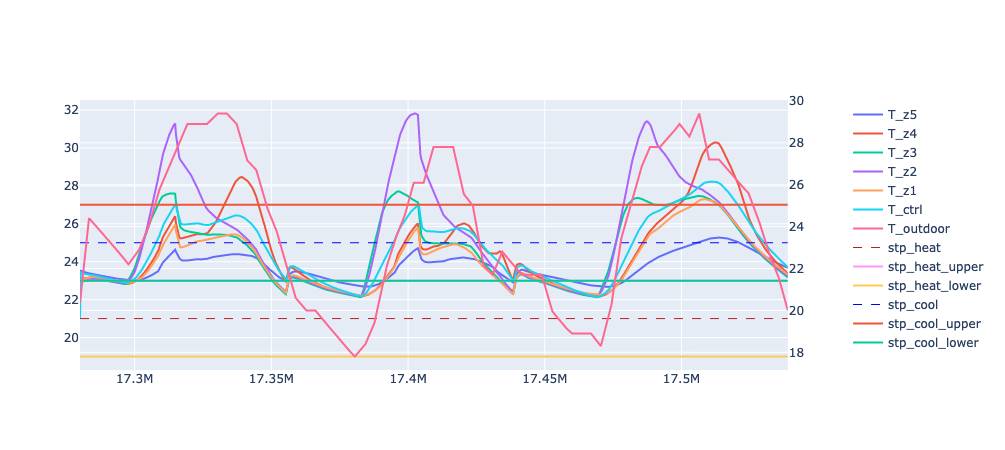

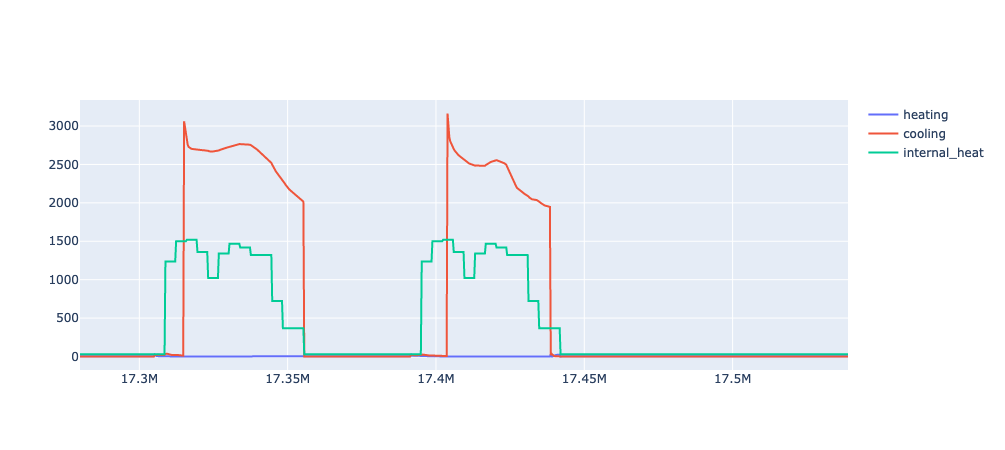

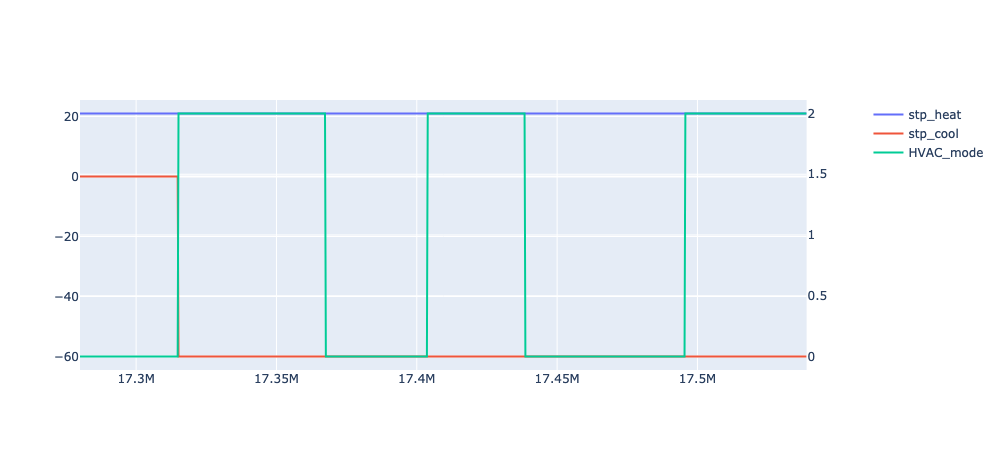

In [12]:
fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE5_1_Zone_Air_Temperature"], mode='lines',name='T_z5'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE4_1_Zone_Air_Temperature"], mode='lines',name='T_z4'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE3_1_Zone_Air_Temperature"], mode='lines',name='T_z3'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE2_1_Zone_Air_Temperature"], mode='lines',name='T_z2'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Air_Temperature"], mode='lines',name='T_z1'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["t_ctrl"], mode='lines',name='T_ctrl'), row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(
    x=df.time_seconds, y=df["FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature"], mode='lines',name='T_outdoor')
              , row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"],
                         mode='lines',
                         line=dict(color='firebrick', width=1,dash='dash'),
                         name='stp_heat'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] + df["deadband"], mode='lines',name='stp_heat_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] - df["deadband"], mode='lines',name='stp_heat_lower'), row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"],
                         mode='lines',
                         line=dict(color='blue', width=1,dash='dash'),
                         name='stp_cool'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"] + df["deadband"], mode='lines',name='stp_cool_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"] - df["deadband"], mode='lines',name='stp_cool_lower'), row=1, col=1, secondary_y=False)

fig.show()

fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_heating"], mode='lines',name='heating'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_cooling"], mode='lines',name='cooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_internal_heat"], mode='lines',name='internal_heat'), row=1, col=1)

fig.show()
fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Heating_Setpoint_Temperature"], mode='lines',name='stp_heat'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Cooling_Setpoint_Temperature"], mode='lines',name='stp_cool'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["HVAC_mode"], mode='lines',name='HVAC_mode'), row=1, col=1, secondary_y=True)
fig.show()
# fig.update_layout(height=800, width=1000, title_text="Simulation results")

# TODO
fix the duplicated ThermostatSetpoint:SingleHeating in prep
add output var for ThermostatSetpoint:SingleHeating

In [13]:
opts = model.simulate_options()
opts['ncp'] = int((final_time) / (60. * 5))

opts['ncp']

864

In [14]:
res = model.simulate(final_time=final_time, options=opts)

Simulation interval    : 0.0 - 259200.0 seconds.
Elapsed simulation time: 0.5764751660001366 seconds.


In [ ]:
res.data_matrix.shape

In [ ]:
col_keys = model_keys.copy()
col_keys.insert(0, "time")

In [ ]:
for i in range(res.data_matrix.shape[0]):
    print(f"{i}: {res.data_matrix[i].any(0)}: {col_keys[i]}")

In [ ]:
res.data_matrix[9]

In [ ]:
res.data_matrix[11]